In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deforestation/DeforestationProject/Amazonie_2018-0000000000-0000000000.tif
/kaggle/input/deforestation/DeforestationProject/Congo_2019-0000000000-0000016384.tif
/kaggle/input/2018congo/DeforestationProject/Congo_2018-0000000000-0000000000.tif


In [4]:
# Installer rasterio et ses dépendances
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.2 MB/s eta 0:00:00:00:0100:01


In [5]:
# 1) Imports
import os, glob, shutil, numpy as np
import rasterio
from rasterio.windows import Window
import torch
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# 2) Ré‑extraction des patches 4 canaux (B4, B3, B2, B8)
PATCH_DIR = '/kaggle/working/NDVI_seq_patches'
shutil.rmtree(PATCH_DIR, ignore_errors=True)
os.makedirs(PATCH_DIR, exist_ok=True)

TIFF_DIRS = {
    '2018': '/kaggle/input/2018congo/DeforestationProject',
    '2019': '/kaggle/input/deforestation/DeforestationProject'
}

for year, d in TIFF_DIRS.items():
    for tif in glob.glob(f"{d}/Congo_{year}-*.tif"):
        base = os.path.basename(tif).replace('.tif','')
        with rasterio.open(tif) as src:
            H, W = src.height, src.width
            for i in range(0, H-256+1, 256):
                for j in range(0, W-256+1, 256):
                    win = Window(j, i, 256, 256)
                    # lire et nettoyer chaque bande
                    B4 = src.read(1, window=win).astype(np.float32)
                    B3 = src.read(2, window=win).astype(np.float32)
                    B2 = src.read(3, window=win).astype(np.float32)
                    B8 = src.read(4, window=win).astype(np.float32)
                    for arr in (B4, B3, B2, B8):
                         np.nan_to_num(arr, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
                    # empilement et normalisation
                    patch = np.stack([B4, B3, B2, B8], axis=0) / 10000.0
                    out = os.path.join(PATCH_DIR, f"{year}_{base}_{i}_{j}.npy")
                    np.save(out, patch)


In [7]:
# 3) Assemblage spatio‑temporel en paires 2018→2019
files18 = glob.glob(f"{PATCH_DIR}/2018_*.npy")
files19 = glob.glob(f"{PATCH_DIR}/2019_*.npy")
idx19 = {}
for f in files19:
    stem = os.path.splitext(os.path.basename(f))[0].split('_')
    coord = (stem[-2], stem[-1])
    idx19[coord] = f

pairs = []
for f in files18:
    stem = os.path.splitext(os.path.basename(f))[0].split('_')
    coord = (stem[-2], stem[-1])
    if coord in idx19:
        pairs.append((f, idx19[coord]))
print(f"→ Nombre de paires 2018→2019 : {len(pairs)}")

→ Nombre de paires 2018→2019 : 2816


In [8]:
# 4) Split train / val / test (70% / 15% / 15%)
train_val, test = train_test_split(pairs, test_size=0.15, random_state=42)
train, val      = train_test_split(train_val, test_size=0.1765, random_state=42)
print(f"Train={len(train)}, Val={len(val)}, Test={len(test)}")

# 5) Dataset & DataLoaders
class ForecastDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        f18, f19 = self.pairs[idx]
        x = np.load(f18).astype(np.float32)      # (4,256,256)
        y4 = np.load(f19).astype(np.float32)     # (4,256,256)
        B4, B8 = y4[0], y4[3]
        ndvi    = (B8 - B4) / (B8 + B4 + 1e-6)
        y = ndvi[None]                           # (1,256,256)
        return torch.from_numpy(x), torch.from_numpy(y)

batch_size = 16
train_loader = DataLoader(ForecastDataset(train), batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(ForecastDataset(val),   batch_size=batch_size, shuffle=False, num_workers=1)
test_loader  = DataLoader(ForecastDataset(test),  batch_size=batch_size, shuffle=False, num_workers=1)

# Vérification de la forme
x, y = next(iter(train_loader))
print(f"→ x.shape: {x.shape}, y.shape: {y.shape}")

Train=1970, Val=423, Test=423
→ x.shape: torch.Size([16, 4, 256, 256]), y.shape: torch.Size([16, 1, 256, 256])


In [9]:
# 6) Définition du modèle
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ForecastCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(4,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1,3,stride=2,padding=1,output_padding=1),
        )
    def forward(self, x):
        return self.dec(self.enc(x))

model     = ForecastCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 01  Train MSE=0.1696  Val MSE=0.0396
Epoch 02  Train MSE=0.0346  Val MSE=0.0402
Epoch 03  Train MSE=0.0331  Val MSE=0.0395
Epoch 04  Train MSE=0.0325  Val MSE=0.0361
Epoch 05  Train MSE=0.0325  Val MSE=0.0430
Epoch 06  Train MSE=0.0335  Val MSE=0.0348
Epoch 07  Train MSE=0.0319  Val MSE=0.0455
Epoch 08  Train MSE=0.0340  Val MSE=0.0376
Epoch 09  Train MSE=0.0322  Val MSE=0.0357
Epoch 10  Train MSE=0.0317  Val MSE=0.0349


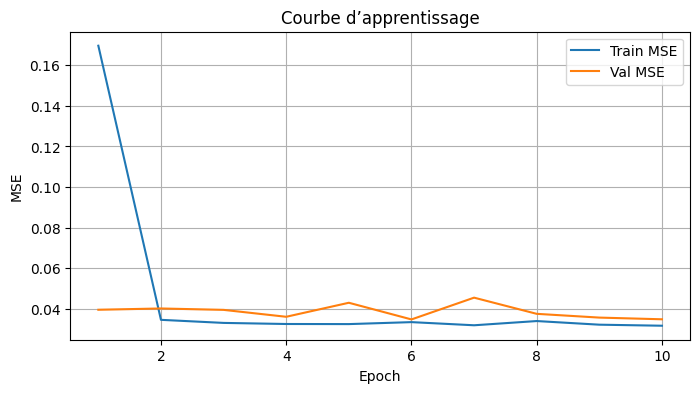

In [10]:
n_epochs = 10
train_losses, val_losses = [], []

for epoch in range(1, n_epochs+1):
    # training
    model.train()
    tl = 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        p   = model(x)
        loss= criterion(p, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tl += loss.item() * x.size(0)
    tl /= len(train_loader.dataset)
    train_losses.append(tl)
    # validation
    model.eval(); vl = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            vl += criterion(model(x), y).item() * x.size(0)
    vl /= len(val_loader.dataset)
    val_losses.append(vl)

    print(f"Epoch {epoch:02d}  Train MSE={tl:.4f}  Val MSE={vl:.4f}")

# Plot
plt.figure(figsize=(8,4))
plt.plot(range(1, n_epochs+1), train_losses, label='Train MSE')
plt.plot(range(1, n_epochs+1), val_losses,   label='Val MSE')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title("Courbe d’apprentissage"); plt.legend(); plt.grid(True)
plt.show()

In [12]:
from rasterio.transform import from_origin


PRED_DIR     = '/kaggle/working/predicted_patches'
OUT_TIF_NDVI = 'full_predicted_ndvi2019.tif'
OUT_TIF_BIN  = 'deforestation_mask.tif'

# Coordonnées spatiales & résolution de ton AOI (à adapter)
minx, maxy, res = -5.0, 0.0, 0.00025

# 3) Prépare le dossier de sortie pour patches prédits
shutil.rmtree(PRED_DIR, ignore_errors=True)
os.makedirs(PRED_DIR, exist_ok=True)

# 4) Génère et enregistre chaque patch prédit (256×256) en .npy
model.eval()
with torch.no_grad():
    for f18, f19 in pairs:
        arr18 = np.load(f18).astype(np.float32)     # (1,256,256) ou (4,256,256)
        x     = torch.from_numpy(arr18[None]).to(device)
        pred  = model(x).cpu().numpy().squeeze()     # (256,256)

        # extraire i,j depuis le nom du fichier f18
        stem = os.path.splitext(os.path.basename(f18))[0]
        parts = stem.split('_')
        i, j = int(parts[-2]), int(parts[-1])

        out_path = os.path.join(PRED_DIR, f"{i}_{j}.npy")
        np.save(out_path, pred)

# 5) Détermine le nombre de tuiles & dimensions totales d’après les prédictions
tiles = glob.glob(os.path.join(PRED_DIR, '*.npy'))
coords = [tuple(map(int, os.path.splitext(os.path.basename(f))[0].split('_')))
          for f in tiles]
is_, js = zip(*coords)
n_rows = max(is_)//256 + 1
n_cols = max(js)//256 + 1
h = n_rows * 256
w = n_cols * 256

# 6) Initialise les mosaïques vides
full_pred = np.zeros((h, w), dtype=np.float32)
full_ori  = np.zeros((h, w), dtype=np.float32)

# 7) Remplit la mosaïque des prédictions
for f in tiles:
    i, j = map(int, os.path.splitext(os.path.basename(f))[0].split('_'))
    full_pred[i:i+256, j:j+256] = np.load(f)

# 8) Remplit la mosaïque de l'original 2018 (seulement pour les mêmes patches)
for f18, _ in pairs:
    stem = os.path.splitext(os.path.basename(f18))[0].split('_')
    i, j = int(stem[-2]), int(stem[-1])
    arr = np.load(f18).astype(np.float32)   # (4,256,256)
    B4, B3, B2, B8 = arr
    # nettoyage NaN/Inf et calcul NDVI
    B4 = np.nan_to_num(B4, nan=0.0, posinf=0.0, neginf=0.0)
    B8 = np.nan_to_num(B8, nan=0.0, posinf=0.0, neginf=0.0)
    den = B8 + B4
    mask = den > 1e-6
    ndvi = np.zeros_like(B4, dtype=np.float32)
    ndvi[mask] = (B8[mask] - B4[mask]) / den[mask]
    full_ori[i:i+256, j:j+256] = ndvi

# 9) Sauvegarde la carte continue de NDVI prédit (GeoTIFF Float32)
transform = from_origin(minx, maxy, res, res)
with rasterio.open(
    OUT_TIF_NDVI, 'w',
    driver='GTiff', height=h, width=w, count=1,
    dtype='float32', crs='EPSG:4326', transform=transform
) as dst:
    dst.write(full_pred, 1)

# 10) Calcul ΔNDVI et carte binaire (UInt8)
delta = full_pred - full_ori
mask  = (delta < -0.1).astype('uint8')
with rasterio.open(
    OUT_TIF_BIN, 'w',
    driver='GTiff', height=h, width=w, count=1,
    dtype='uint8', crs='EPSG:4326', transform=transform
) as dst:
    dst.write(mask, 1)

print(f"→ Sorties générées :\n   • {OUT_TIF_NDVI}\n   • {OUT_TIF_BIN}")








→ Sorties générées :
   • full_predicted_ndvi2019.tif
   • deforestation_mask.tif


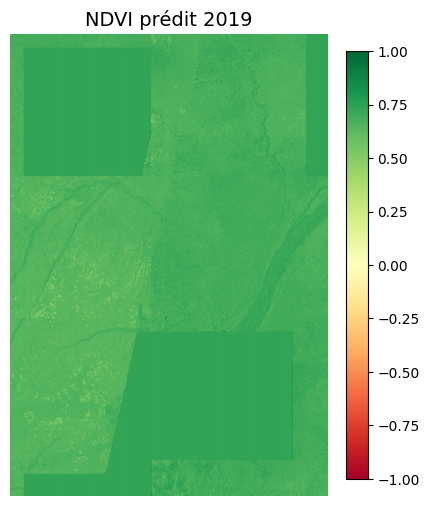

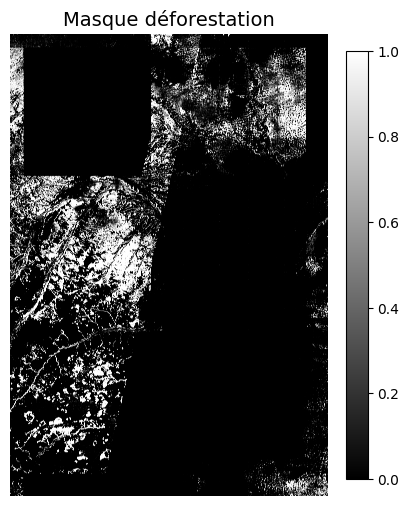

In [13]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

def display_tif(path, cmap='viridis', vmin=None, vmax=None, title=None):
    """Charge et affiche la première bande d’un GeoTIFF."""
    with rasterio.open(path) as src:
        arr = src.read(1)
        fig, ax = plt.subplots(figsize=(6,6))
        im = ax.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax)
        if title:
            ax.set_title(title, fontsize=14)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.show()

#  NDVI prédite
display_tif(
    'full_predicted_ndvi2019.tif',
    cmap='RdYlGn',
    vmin=-1, vmax=1,
    title='NDVI prédit 2019'
)

# n masque binaire de déforestation
display_tif(
    'deforestation_mask.tif',
    cmap='gray',
    vmin=0, vmax=1,
    title='Masque déforestation'
)
